In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

A search has been initiated within the folder named 'Fundus '.
There are 247 images in the large optic folder.
There are 250 images in the myopia folder.
There are 250 images in the normal folder.
There are 250 images in the blur folder.
The search has been completed.


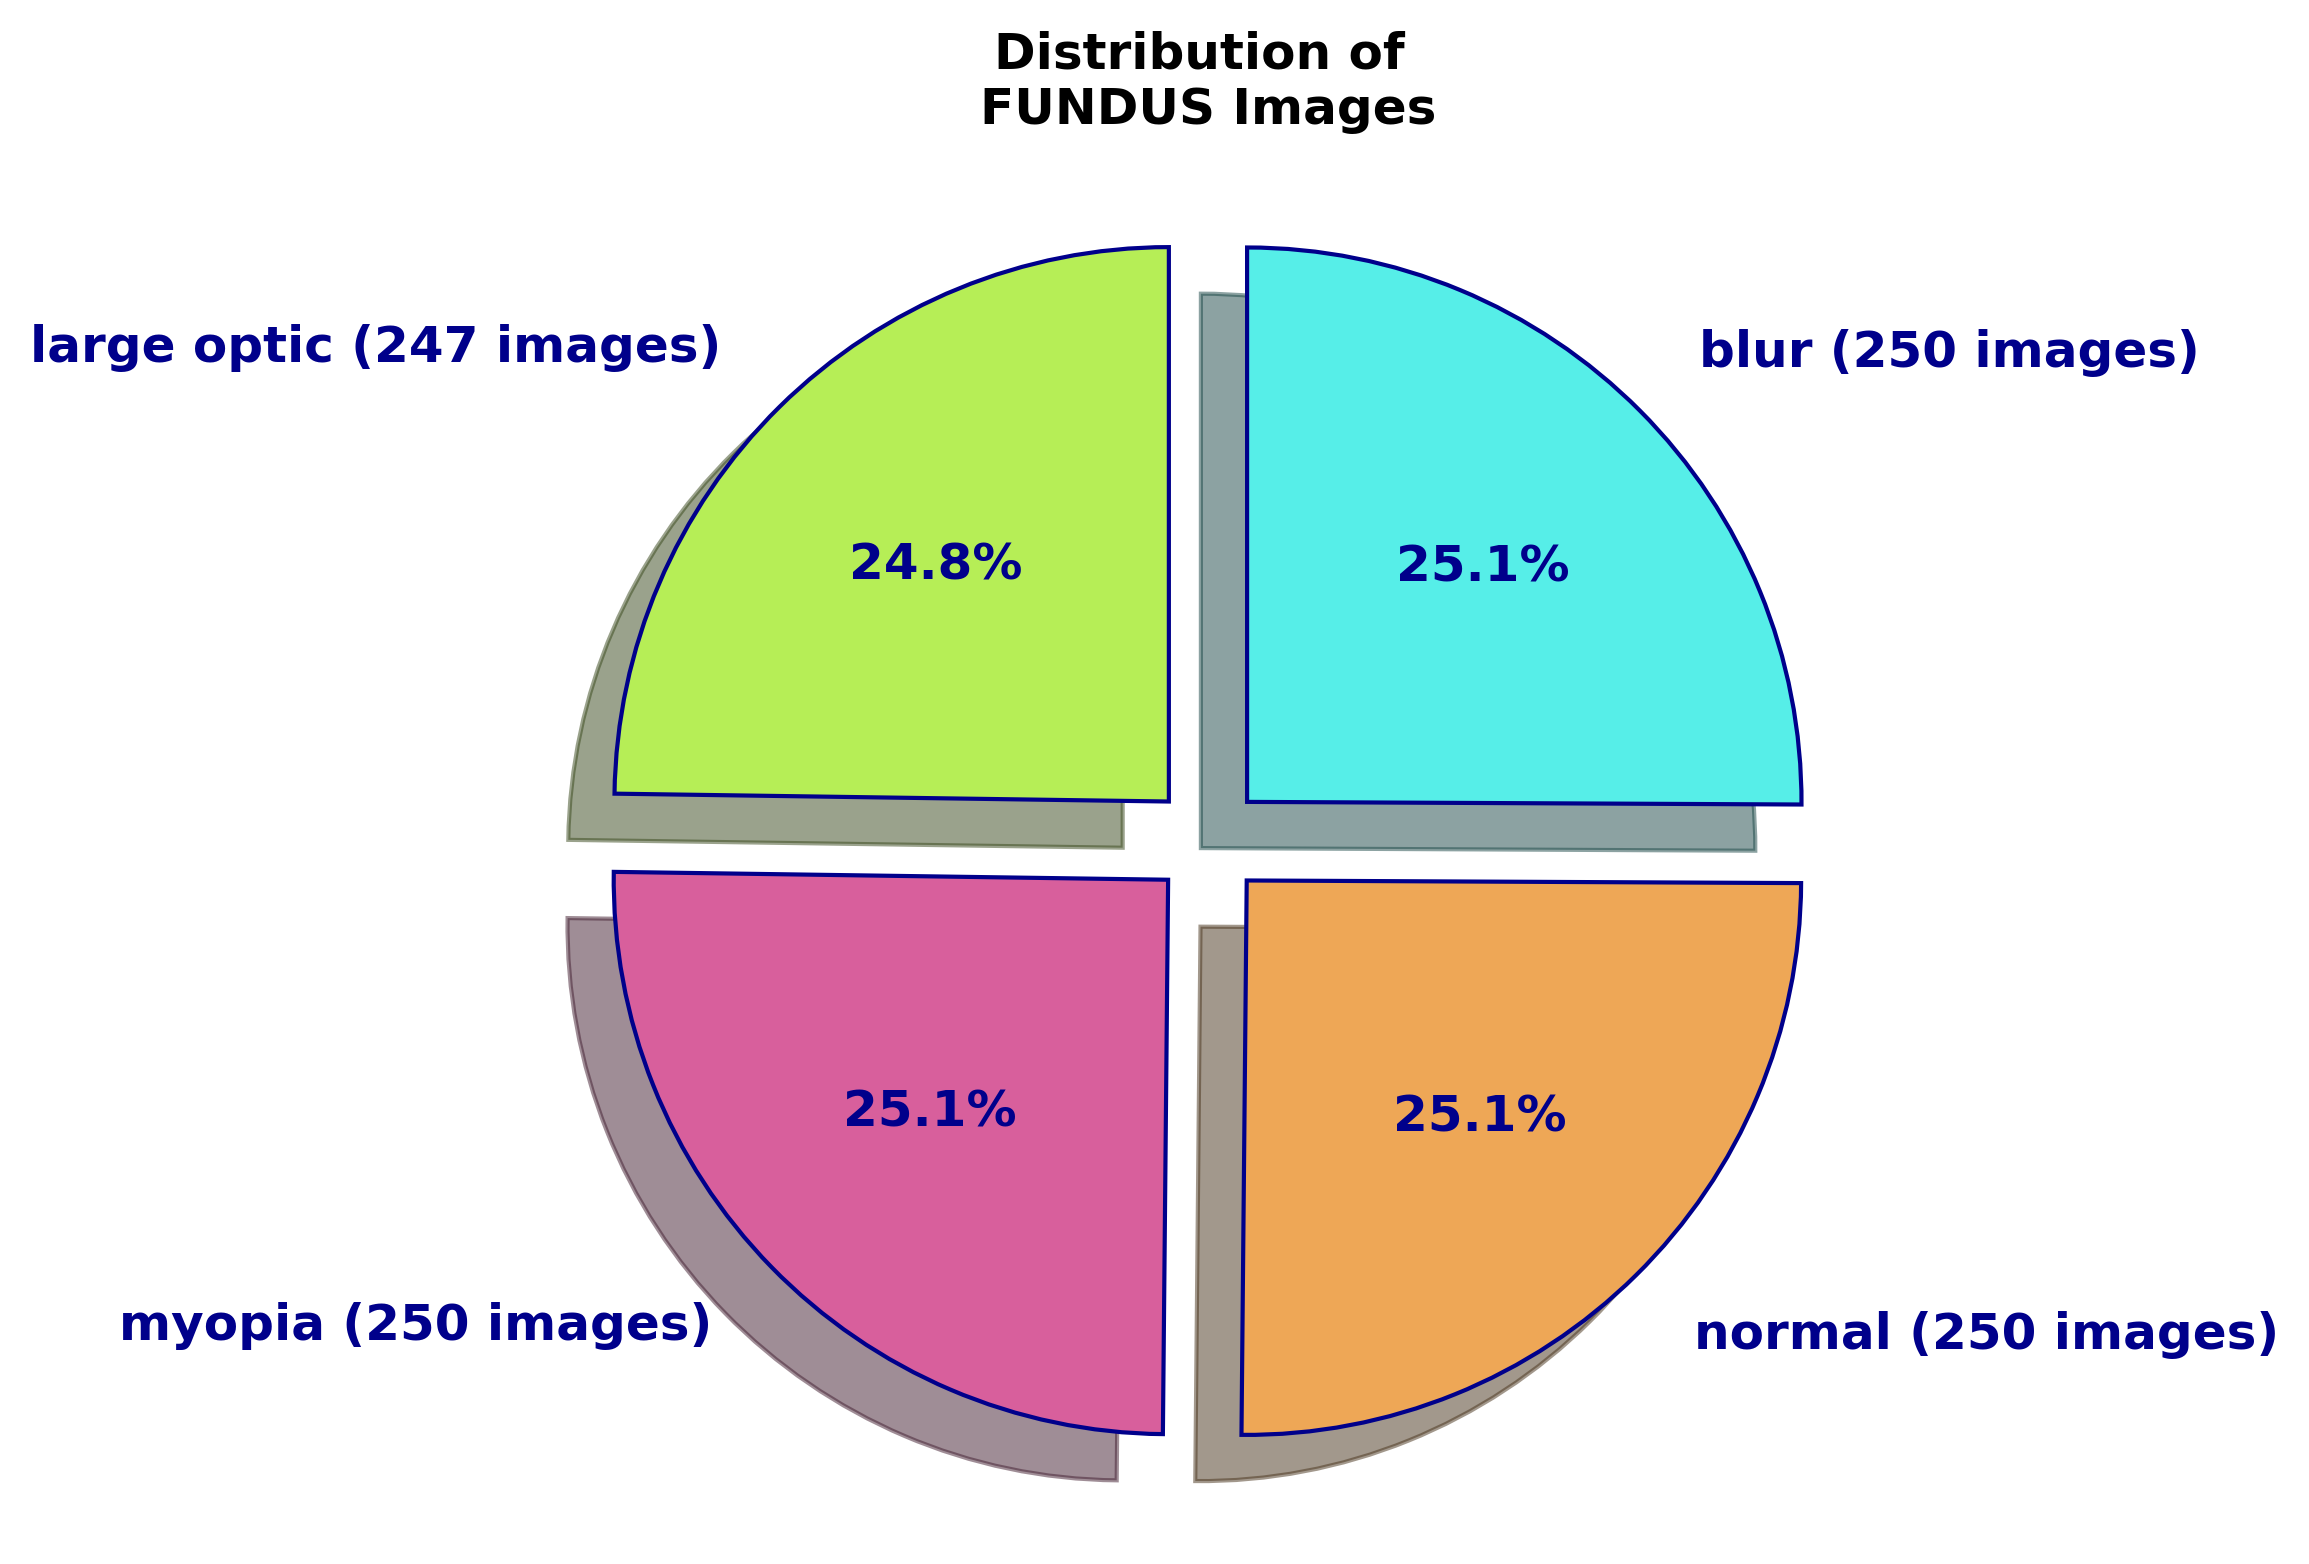

In [ ]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1

            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)

    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nFUNDUS Images", size=12, fontweight="bold")

PATH = '/content/drive/MyDrive/Fundus '

image_counter(PATH)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 997 files belonging to 4 classes.


NameError: name 'img' is not defined

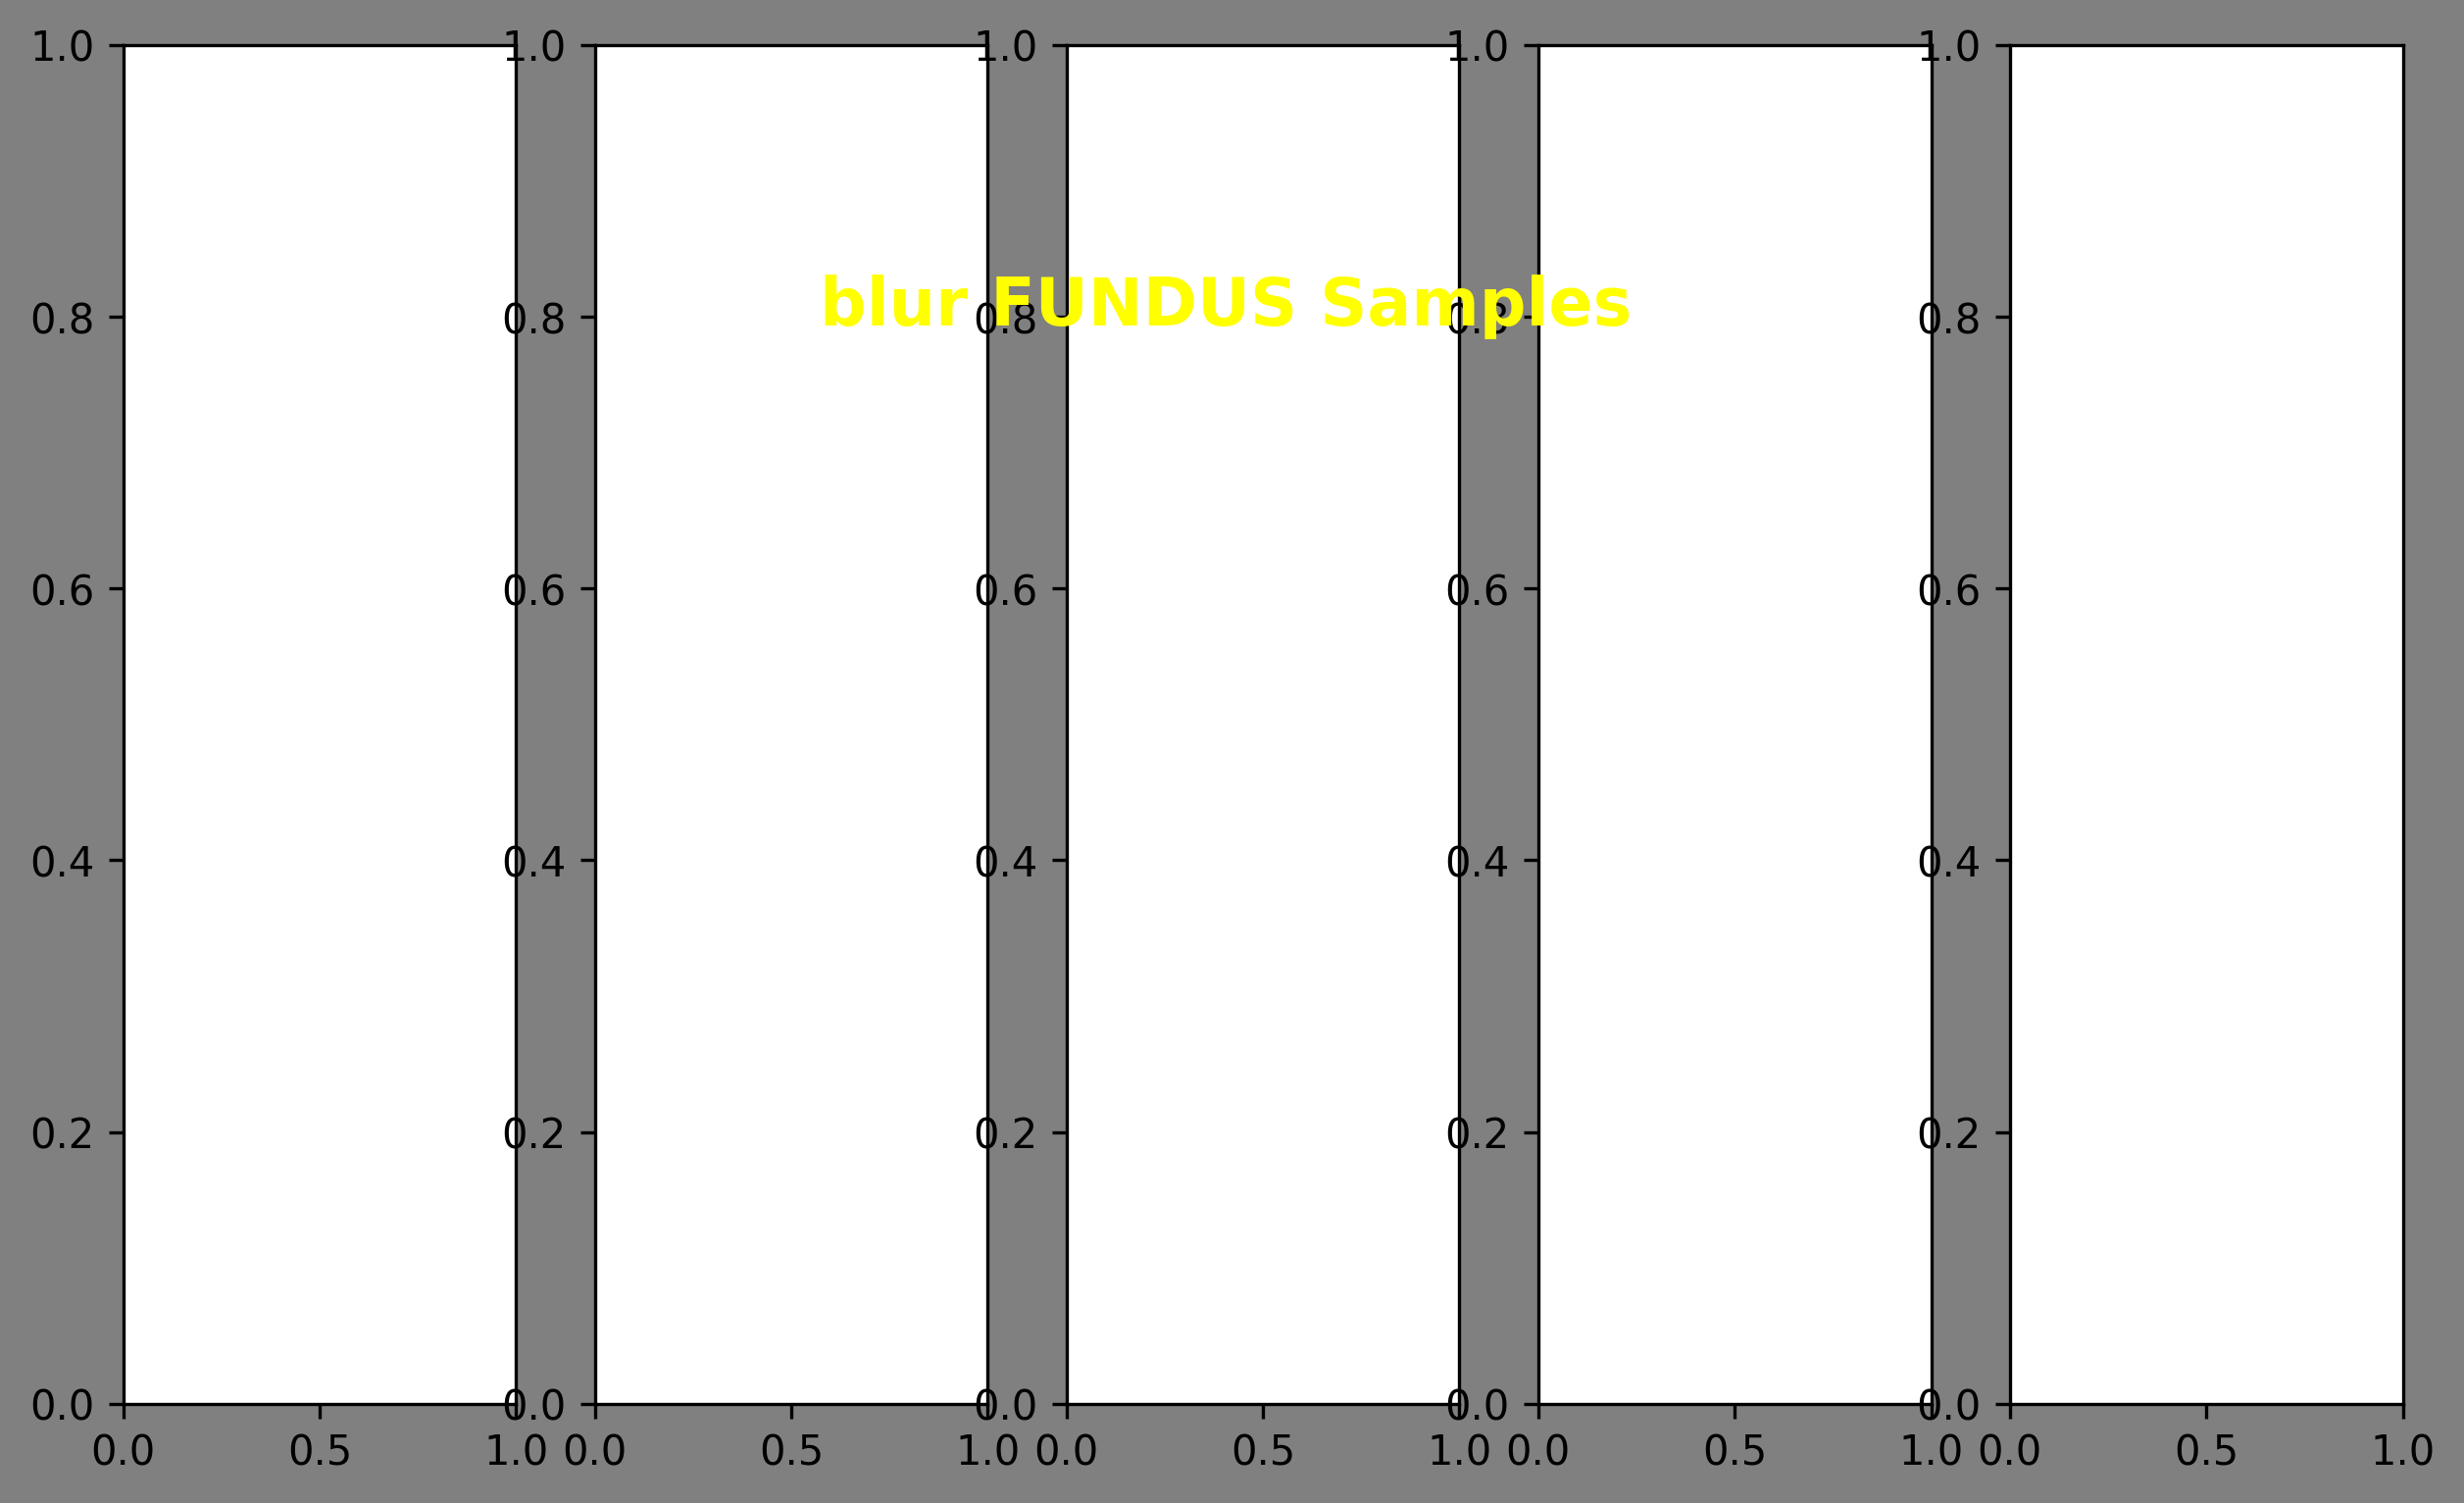

In [ ]:
def sample_bringer(path, target, num_samples=5):

    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray")
    fig.suptitle(f'{target} FUNDUS Samples', color="yellow",fontsize=16, fontweight='bold', y=0.75)

    for i in range(num_samples):
       # image_path = os.path.join(class_path, image_files[i])
       # img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()

for target in class_names:
    sample_bringer(PATH, target=target)

In [ ]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("FUNDUS SAMPLES", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Min and max pixel values in the batch -> 0.0 & 1.0


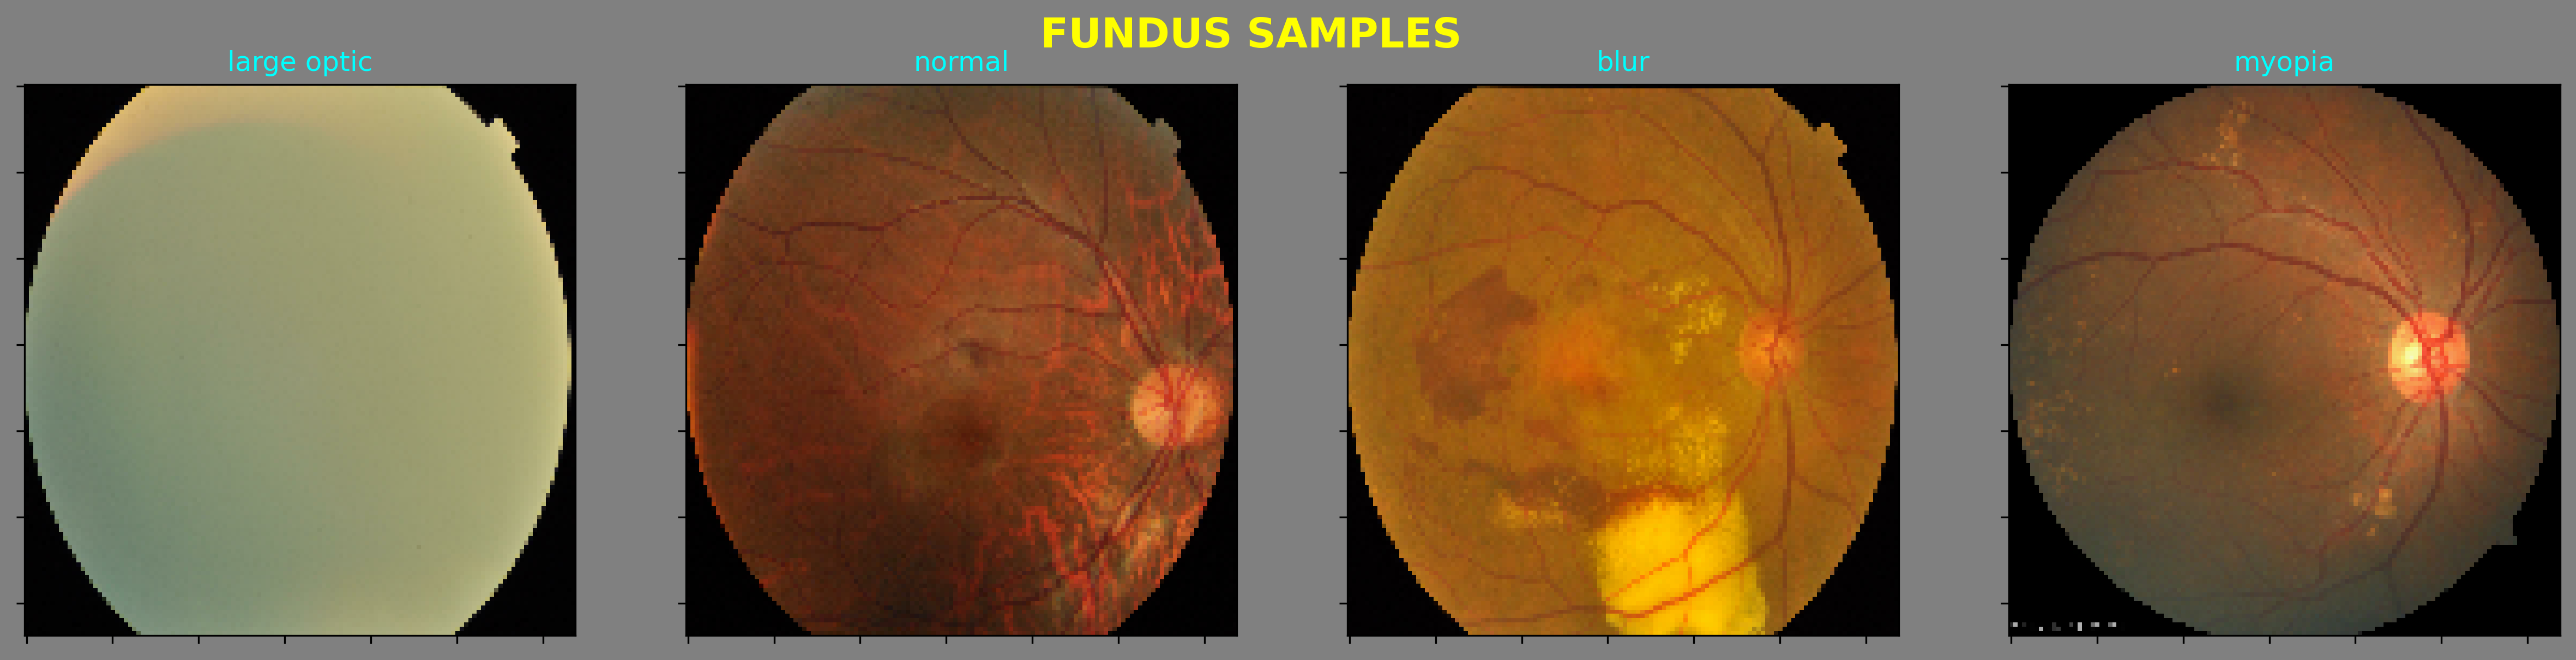

In [ ]:
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=4)

In [ ]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

In [ ]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

Model Building

In [ ]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed

def build_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add TimeDistributed layer to make the output 3D
    model.add(TimeDistributed(Flatten()))

    # Add LSTM layer
    model.add(LSTM(units=64, activation='relu'))

    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model.summary()

    return model

model = build_model()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

CheckPoints

In [ ]:
def checkpoint_callback():

    checkpoint_filepath = '/tmp/checkpoint'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 25
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [ ]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/25
25/25 [==============================] - ETA: 0s - loss: 1.3950 - accuracy: 0.3013
Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to /tmp/checkpoint
25/25 [==============================] - 88s 3s/step - loss: 1.3950 - accuracy: 0.3013 - val_loss: 1.3391 - val_accuracy: 0.3750
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 1.3335 - accuracy: 0.3425
Epoch 2: val_accuracy improved from 0.37500 to 0.51042, saving model to /tmp/checkpoint
25/25 [==============================] - 82s 3s/step - loss: 1.3335 - accuracy: 0.3425 - val_loss: 1.3014 - val_accuracy: 0.5104
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 1.2934 - accuracy: 0.3975
Epoch 3: val_accuracy did not improve from 0.51042
25/25 [==============================] - 78s 3s/step - loss: 1.2934 - accuracy: 0.3975 - val_loss: 1.2406 - val_accuracy: 0.4792
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 1.2417 - accuracy: 0.4450
Epoch 4: val_

Loss and Accuracy


In [ ]:
# Save the trained model
model.save("your_model_name.h5")


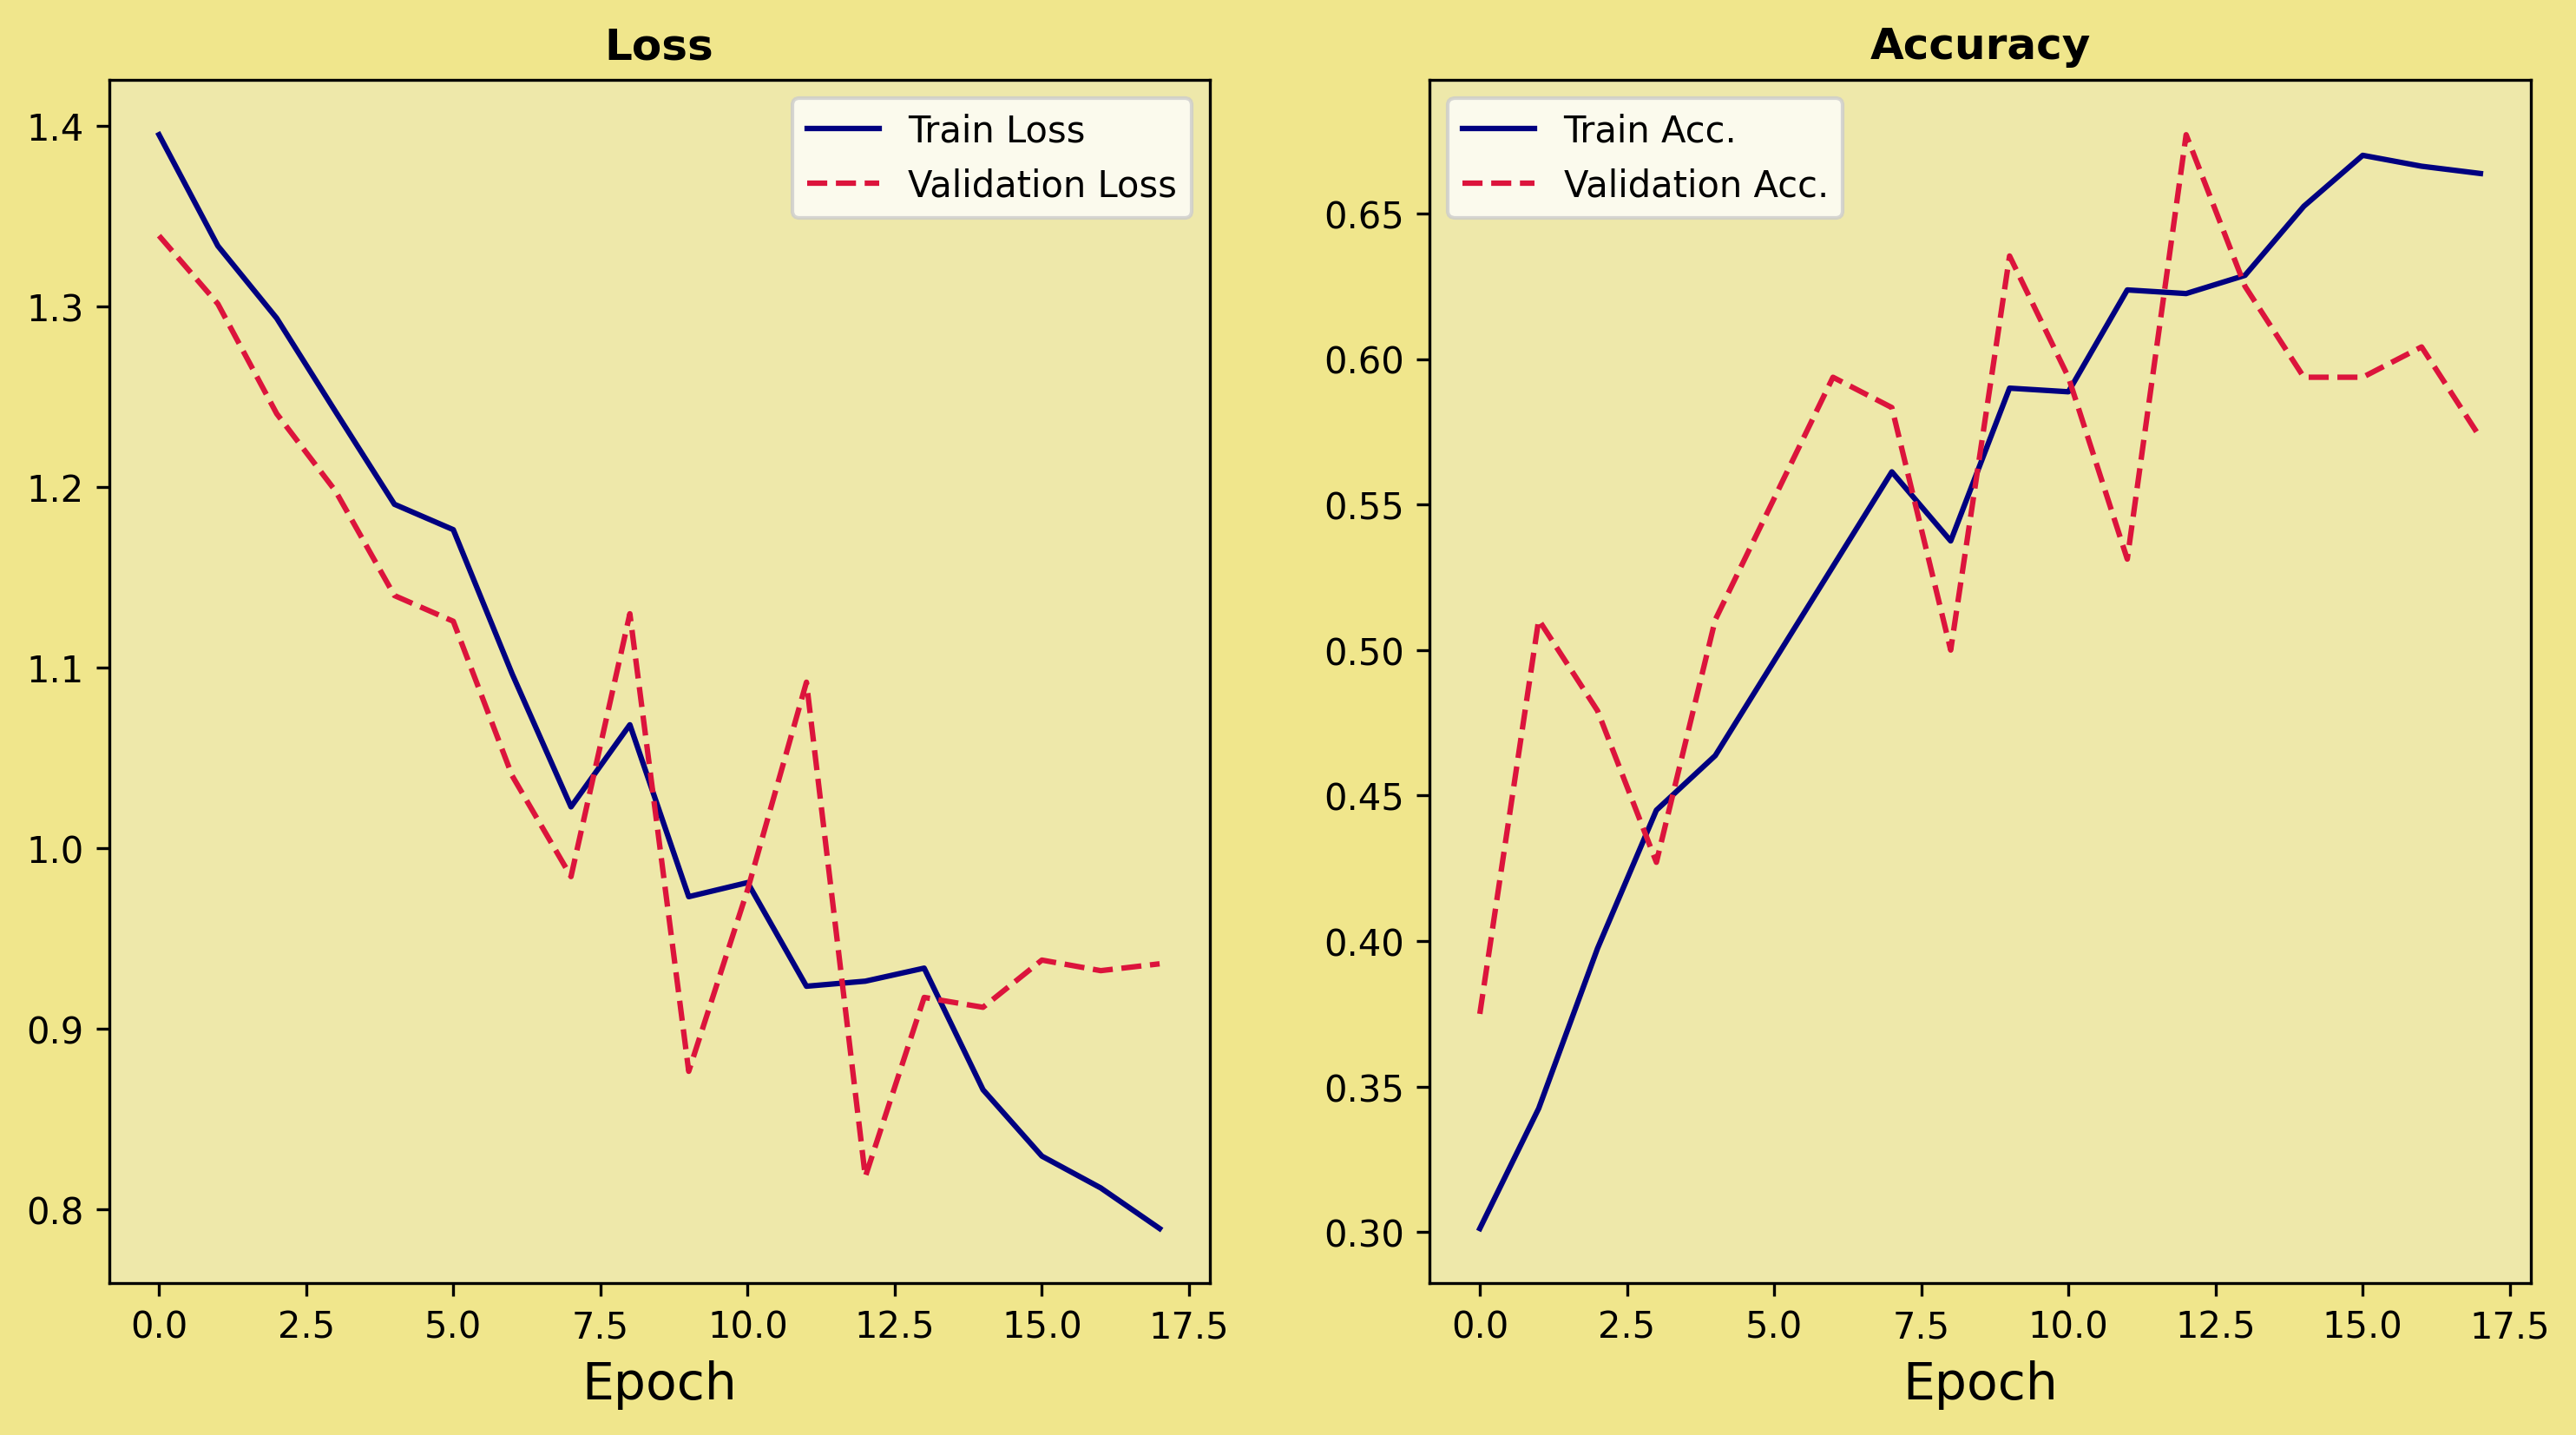

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

Evaluating Test Data


In [ ]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

        blur       0.78      0.64      0.70        33
 large optic       0.59      0.85      0.69        20
      myopia       0.62      0.75      0.68        20
      normal       0.94      0.65      0.77        23

    accuracy                           0.71        96
   macro avg       0.73      0.72      0.71        96
weighted avg       0.74      0.71      0.71        96



Confusion Matrix

Text(287.16666666666663, 0.5, 'True')

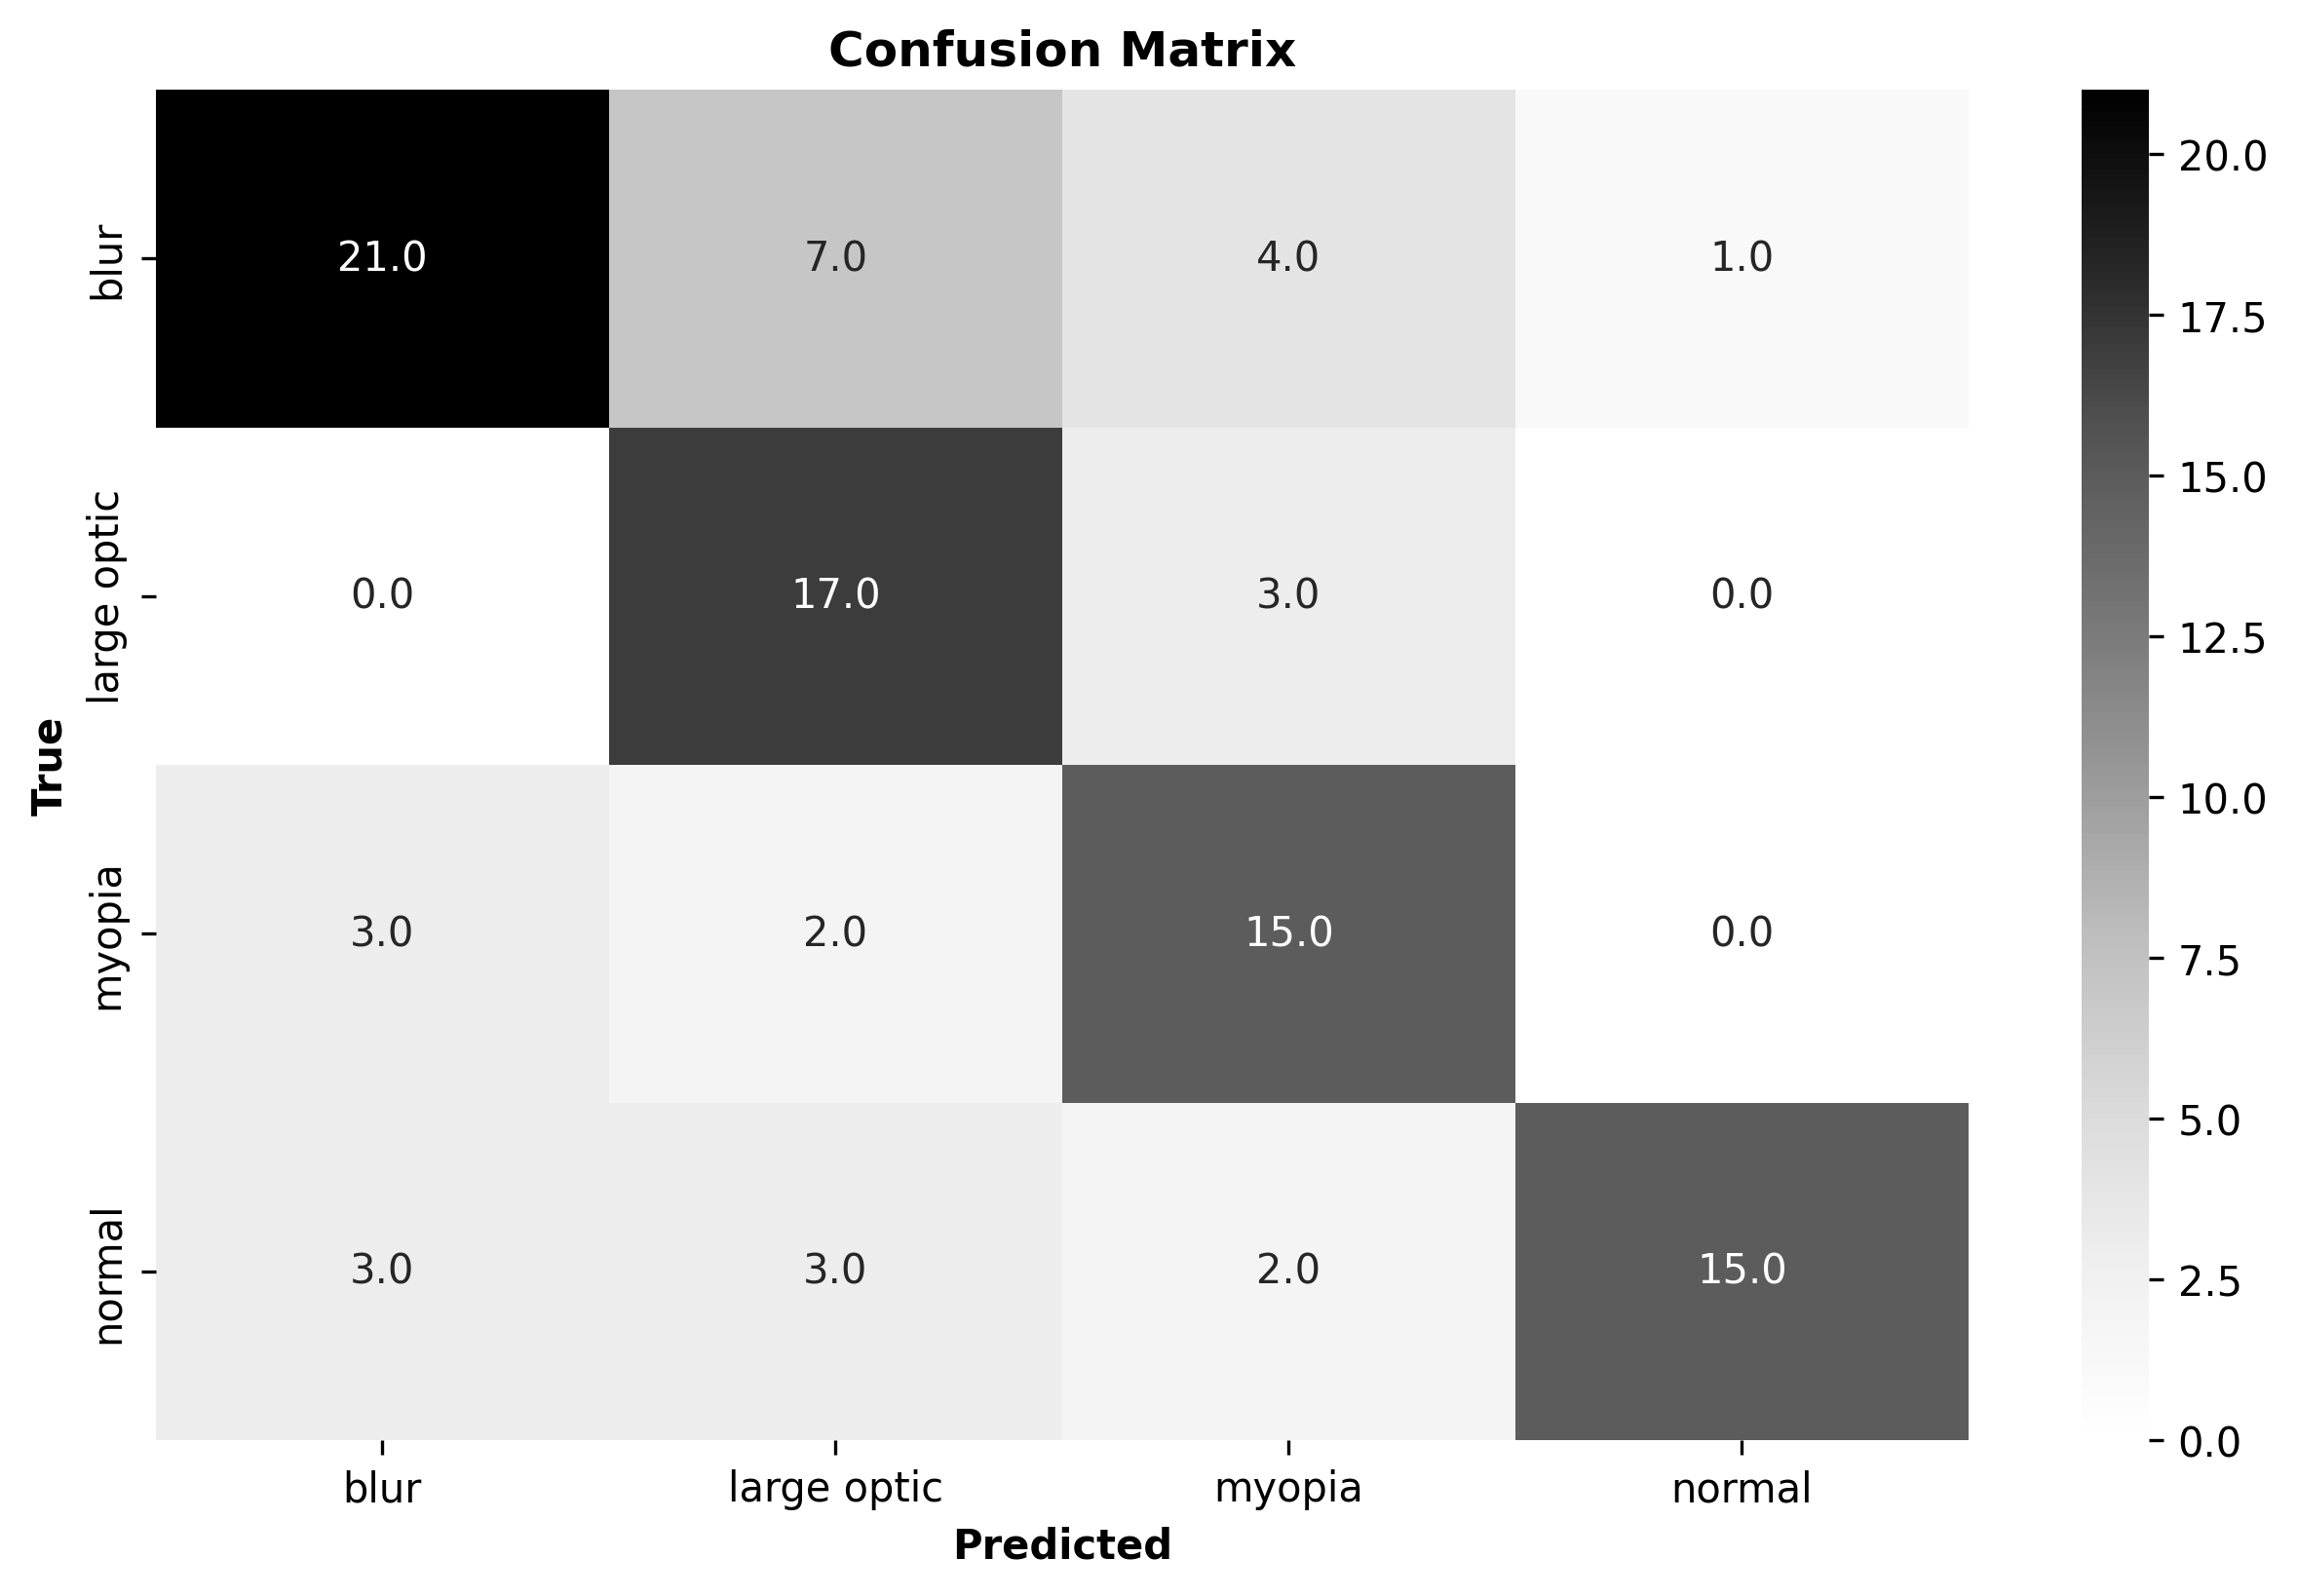

In [ ]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")


 Probability of a FUNDUS IMAGES from Test Data

In [ ]:
def random_mri_prob_bringer(image_number=0):

    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = model.predict(tf.expand_dims(image, 0))[0]

    probs = list(tf.nn.softmax(pred).numpy())
    probs_dict = dict(zip(class_dist.keys(), probs))

    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4)
    ax1.imshow(image)
    ax1.set_title('photo', color="yellow", fontweight="bold", fontsize=16)

    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('Fundus Probabilities', color="yellow", fontweight="bold", fontsize=16)

rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)

UnboundLocalError: local variable 'pred' referenced before assignment

Comparing Predicted Classes with the Actual Classes from the Test Data

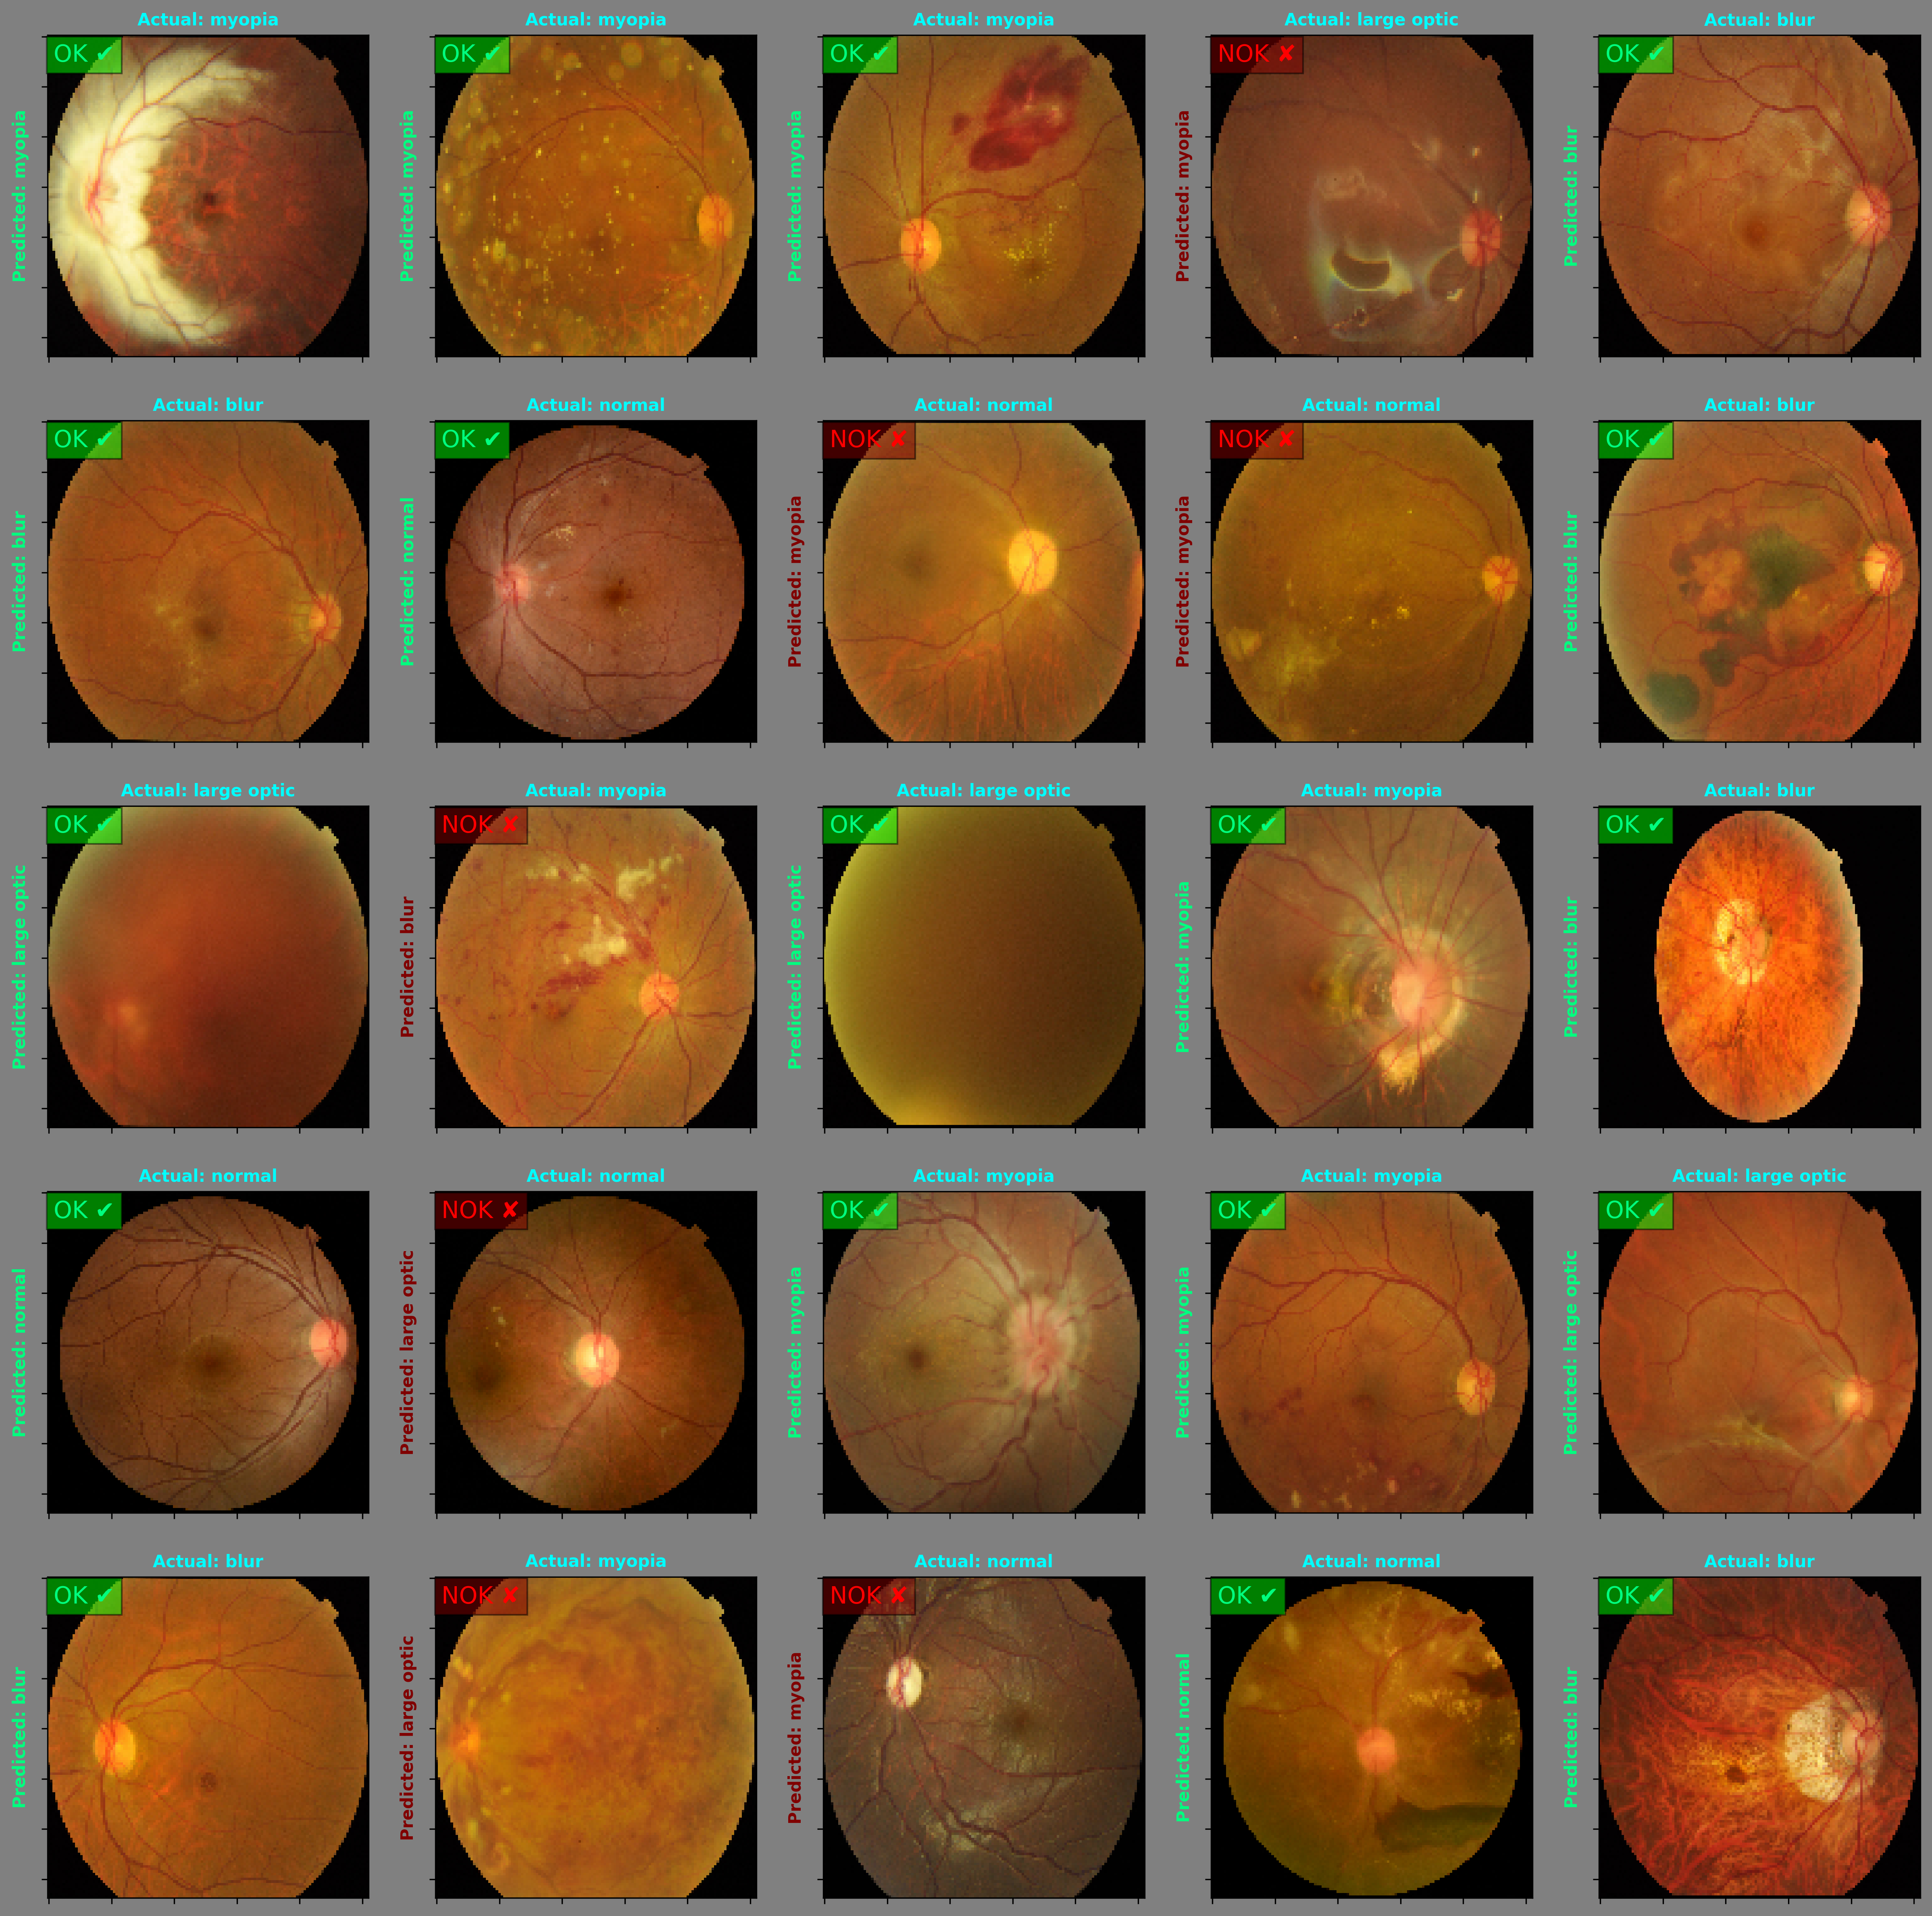

In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])